In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import logging
from numpy import convolve
from matplotlib.gridspec import GridSpec
import bilby
import time as timer
from scipy import signal
global fch1,bwchan,nchan,ftop,fcentre
from astropy import units as u
MIN_FLOAT = sys.float_info[3]
fch1=1104 ## Fch1 1104 MHz
bwchan=1## bwchan 1 MHz
nchan=336## nchan=336
ftop=fch1/1000 ##GHz
fcentre=(fch1+bwchan*nchan/2)/1000 ##GHz
print("fch1,bwchan(MHz),nchan,ftop,fcentre")
print(fch1,bwchan,nchan,ftop,fcentre,fch1+bwchan*336)

13:20 bilby INFO    : Running bilby version: 0.5.2:
13:20 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
13:20 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.


fch1,bwchan(MHz),nchan,ftop,fcentre
1104 1 336 1.104 1.272 1440


In [2]:
filex='t_x_total_dm589.265_tr.npy'
filey='t_y_polcal_total_dm589.265_tr.npy'
basetsamp=1/336e6*u.second
xpol=np.load(filex)
ypol=np.load(filey)

In [3]:
realx=np.abs(xpol)
realy=np.abs(ypol)
stokesI=(realx**2+realy**2)

5504856.0 (169, 16384) (5505024,) [0.5]
spectrogram time axis length (16384,)
binned stokesI axis (16384,)
true time resolution in spectrogram 1.0 us
(168, 4096) 4.0 us


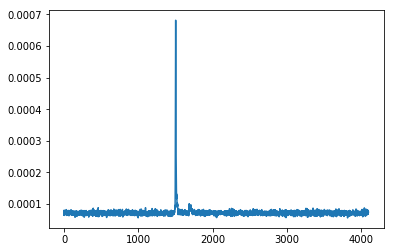

1.9881656804733727 4.0


In [4]:
f, t, Sxx=signal.spectrogram(stokesI,fs=1,nperseg=336,noverlap=0)
tbin=4
print(t[-1],Sxx.shape,stokesI.shape,(stokesI.shape-t[-1])/336)
print('spectrogram time axis length',Sxx.sum(axis=0).shape)
print('binned stokesI axis',stokesI.reshape(-1,336).sum(1).shape)
#print(stokesI.shape[0]/Sxx.sum(axis=0).shape[0])
newtsamp=stokesI.shape[0]/Sxx.sum(axis=0).shape[0]*basetsamp.to(u.us)
print('true time resolution in spectrogram',newtsamp)
data=Sxx[:168,:].reshape(168,int(16384/tbin),tbin).sum(2)
tsamp=newtsamp*tbin
print(data.shape,tsamp)
np.save(arr=data,file='frb_hightime')
tsamp=tsamp.value
plt.plot(data.sum(0))
plt.show()
nchan=169
bwchan=336/nchan
print(bwchan,tsamp)

# Functions for FRB with scattering as follows

In [5]:
### gaussian
def gaus_func(sigi,t0,t,ti):
    sit=1/np.sqrt(np.pi*2*(sigi**2))*np.exp(-(t-t0-ti)**2/sigi**2) ### model 0 in ravi 2018
    return sit

### adjust dm
def tidm(dmerr,vi):
    beta=2
    #ftop=1464/1000 ## MHz--->GHz
    #fbot=1128/1000 ## MHz--->GHz
    ### ftop GHz
    ### 4.15 ms
    ti=4.15*dmerr*(ftop**(-beta)-vi**(-beta)) ### ms
    return ti

### scattering
def scat(t,t0,tau1,alpha,v):
    ###tau=tau1/1000 ## ms
    flux=np.zeros(len(t)) + MIN_FLOAT
    flux[t>=t0]=np.exp(-(t[t>=t0]-t0)/(tau1*(v/fcentre)**(-alpha)))
    return flux

### dm smearing
def delta_t(dm,v):
    ### calculate dm smearing
    beta=2
    dt=1.622e-3*dm*(v**(-beta-1)) ### v is GHz / dt is ms
    return dt

In [6]:
def scat_pulse(t,t0,tau1,dm,dmerr,sigma,alpha,a,vi):
    ### vi is GHz, dmerr is milli-DM
    dmerr=dmerr/1000

    dm_0=dm+dmerr 
    ti=tidm(dmerr,vi)*1000##ms--->us
    #smear=delta_t(dm_0,vi) ##ms
    smear=0
    width=np.sqrt(sigma**2+smear**2)
    gt0=np.mean(t)
    pulse=gaus_func(width,gt0,t,ti) ## create pulse
    scat_corr=scat(t,t0,tau1,alpha,vi) ## create scatter kernel
    flux=convolve(scat_corr,pulse,'same')
    flux/=np.max(flux) ### normalise
    return a*flux

def single_pulse(t,t0,dm,dmerr,sigma,a,vi):
    ### vi is GHz
    dmerr=dmerr/1000
    dm_0=dm+dmerr 
    ti=tidm(dmerr,vi)*1000##ms--->us
    width=sigma
    pulse=gaus_func(width,t0,t,ti) ## create pulse
    flux=pulse
    flux/=np.max(flux) ### normalise
    return a*flux
#### get a frequency splitter
def freq_splitter_idx(n,skip,end):
    dw=(end-skip)/n
    print(dw,bwchan)
    vi=np.arange(n)*dw*bwchan+0.5*dw*bwchan
    base=fch1+skip*bwchan
    vi=base+vi
    chan_idx=np.arange(n)*dw+skip
    chan_idx=np.append(chan_idx,end)
    chan_idx=chan_idx.astype(np.int)
    return vi,chan_idx
#### load data with this

def dataloader(name,chan_idx,head=10,tail=40):
    data=np.load(name)
    data=(data.T-np.median(data,1)).T
    #stokesI_rms=np.loadtxt("FRB_HTR_xpol-imageplane-rms.stokesI.txt")[1:].T
    #print("bandwidth GHz/MHz",bwchan,bwchan*1000)
    #print(data.shape)
    #print(ftop,vi,chan_idx)
    time=np.arange(data.shape[1])*tsamp
    #ytot=data.std()
    #print(ytot)
    sigma=[]
    ydata=[]
    for i in range(len(chan_idx)-1):
        ytot=data[chan_idx[i]:chan_idx[i+1]].mean(axis=0).std()
        ydata.append(data[chan_idx[i]:chan_idx[i+1]].mean(axis=0)/ytot)
        sigma.append(ytot)
    ydata=np.array(ydata)
    print (ydata.shape)
    x0=np.argmax(data.mean(axis=0)/ytot)
    print(time[x0],'peak data')
    ydata=ydata[:,x0-head:x0+tail]
    time=np.arange(ydata.shape[1])*tsamp
    return time,ydata,sigma


21.0 1.9881656804733727
[1124.87573964 1166.62721893 1208.37869822 1250.13017751 1291.8816568
 1333.63313609 1375.38461538 1417.13609467] [  0  21  42  63  84 105 126 147 168]
(8, 4096)
6008.0 peak data


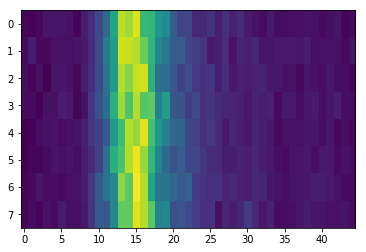

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164.
 168. 172. 176.] 4.0


In [7]:
vi,chan_idx=freq_splitter_idx(n=8,skip=0,end=168)
print(vi,chan_idx)
global freq,dm
freq=np.array(vi)/1000 ## GHz
dm=589.265 ###dm value


time,ydata,err=dataloader("frb_hightime.npy",chan_idx,head=15,tail=30)

plt.imshow(ydata,aspect='auto')
plt.show()
print(time,tsamp)

In [8]:
def multiband_double(t,t1,t2,dmerr,sigi,sigi2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    b_list=np.array([b1,b2,b3,b4,b5,b6,b7,b8])
    model=[]
    sigma=sigi
    sigma2=sigi2
    for vi,am,b in zip(freq,amp_list,b_list):
        #print (vi,am)
        flux1=single_pulse(t,t1,dm,dmerr,sigma,am,vi)
        flux2=single_pulse(t,t2,dm,dmerr,sigma2,b,vi)
        model.append(flux1+flux2)
    return np.array(model)
def multibandscat(t,t0,tau1,dmerr,sigi,alpha,a1,a2,a3,a4,a5,a6,a7,a8):
    amp_list=np.array([a1,a2,a3,a4,a5,a6,a7,a8])
    model=[]
    sigma=sigi
    for vi,am in zip(freq,amp_list):
        #print (vi,am)
        model.append(scat_pulse(t,t0,tau1,dm,dmerr,sigma,alpha,am,vi))
    return np.array(model)


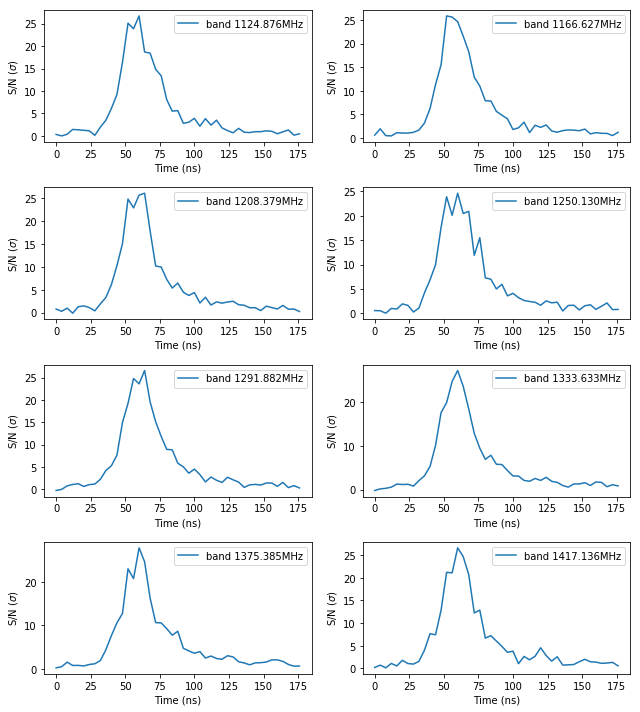

In [9]:
o='htr_test_noscattering_round2'
plt.figure(figsize=(9,10))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(time,ydata[i],label="band "+"{0:.3f}".format(vi[i])+"MHz")
    #plt.plot(time,np.ones(len(time))*0.02,linestyle="--",label="rms from dynesty")
    plt.legend()
    plt.ylabel('S/N ($\sigma$)')
    plt.xlabel('Time (ns)')
plt.tight_layout()

#plt.savefig(o+"_p1_subbands.png",dpi=300)
plt.show()
plt.close()

## Test multipulse model

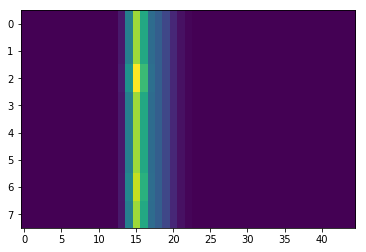

In [10]:
plt.imshow(multiband_double(time,t1=60,t2=70,dmerr=0,sigi=5,sigi2=10,a1=25,a2=25,a3=30,a4=25,a5=25
                      ,a6=25,a7=27,a8=25,b1=10,b2=10,b3=10,b4=10,b5=10,b6=10,b7=10,b8=10),aspect='auto')
#plt.figure()
#plt.plot(scat_pulse(t=time,t0=,tau1,dm,dmerr,sigma,alpha,a,vi))
plt.show()

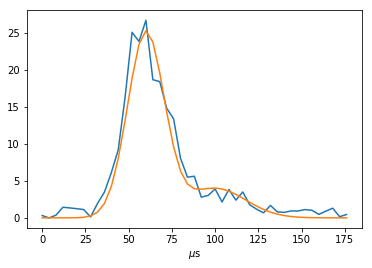

In [11]:
plt.plot(time,ydata[0])
#plt.plot(time,single_pulse(time,t0=60,dm=0,dmerr=0,sigma=20,a=25,vi=1120))  ### test simple
#plt.plot(time,single_pulse(time,t0=60,dm=0,dmerr=5,sigma=20,a=25,vi=1120)) ### test dmerr works or not
plt.plot(time,single_pulse(time,t0=60,dm=0,dmerr=0,sigma=15,a=25,vi=1120)
         +single_pulse(time,t0=100,dm=0,dmerr=0,sigma=25,a=4,vi=1120)) #### test multigaus
plt.xlabel("$\mu$s")
plt.show()

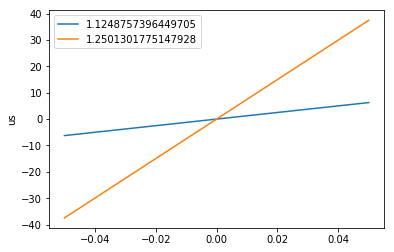

In [12]:
testdm=np.linspace(-0.05,0.05,100)
plt.plot(testdm,tidm(testdm,freq[0])*1000,label=freq[0])
plt.plot(testdm,tidm(testdm,freq[3])*1000,label=freq[3])
plt.legend()
plt.ylabel("us")
plt.show()

In [24]:
amin=0.1
amax=50
taumax=50 ### us
simpoints=500
##t1,t2,dmerr,sigi,sigi2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8
global priors1
print(10*tsamp,20*tsamp)
priors1 = bilby.core.prior.PriorDict()
priors1["t1"]=bilby.core.prior.Uniform(name='t1', minimum=10*tsamp,maximum=20*tsamp) ###
priors1["t2"]=bilby.core.prior.Uniform(name='t2', minimum=25*tsamp,maximum=40*tsamp) ###

priors1["a1"]=bilby.core.prior.Uniform(name='a1', minimum=amin, maximum=amax)
priors1["a2"]=bilby.core.prior.Uniform(name='a2', minimum=amin, maximum=amax)
priors1["a3"]=bilby.core.prior.Uniform(name='a3', minimum=amin, maximum=amax)
priors1["a4"]=bilby.core.prior.Uniform(name='a4', minimum=amin, maximum=amax)
priors1["a5"]=bilby.core.prior.Uniform(name='a5', minimum=amin, maximum=amax)
priors1["a6"]=bilby.core.prior.Uniform(name='a6', minimum=amin, maximum=amax)
priors1["a7"]=bilby.core.prior.Uniform(name='a7', minimum=amin, maximum=amax)
priors1["a8"]=bilby.core.prior.Uniform(name='a8', minimum=amin, maximum=amax)
priors1["b1"]=bilby.core.prior.Uniform(name='b1', minimum=amin, maximum=10)
priors1["b2"]=bilby.core.prior.Uniform(name='b2', minimum=amin, maximum=10)
priors1["b3"]=bilby.core.prior.Uniform(name='b3', minimum=amin, maximum=10)
priors1["b4"]=bilby.core.prior.Uniform(name='b4', minimum=amin, maximum=10)
priors1["b5"]=bilby.core.prior.Uniform(name='b5', minimum=amin, maximum=10)
priors1["b6"]=bilby.core.prior.Uniform(name='b6', minimum=amin, maximum=10)
priors1["b7"]=bilby.core.prior.Uniform(name='b7', minimum=amin, maximum=10)
priors1["b8"]=bilby.core.prior.Uniform(name='b8', minimum=amin, maximum=10)

priors1["dmerr"]=bilby.core.prior.Uniform(name='dmerr(DM/1000)', minimum=-10,maximum=10)
priors1["sigi"]=bilby.core.prior.Uniform(name='$\\sigma$', minimum=0.05, maximum=20)
priors1["sigi2"]=bilby.core.prior.Uniform(name='$\\sigma$', minimum=20, maximum=100)
priors1["sigma"]=bilby.core.prior.Uniform(name='error',minimum=0.001,maximum=5)

40.0 80.0


In [25]:
likelihood = bilby.core.likelihood.GaussianLikelihood(x=time, y=ydata,func=multiband_double, sigma=None)

In [ ]:
result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty'
                                       ,npoints=simpoints,clean=True,dlogz=0.1,outdir='outdir',label=o)

15:38 bilby INFO    : Running for label 'htr_test_noscattering_round2', output will be saved to 'outdir'
15:38 bilby INFO    : Search parameters:
15:38 bilby INFO    :   t1 = Uniform(minimum=40.0, maximum=80.0, name='t1', latex_label='t1', unit=None, boundary=None)
15:38 bilby INFO    :   t2 = Uniform(minimum=100.0, maximum=160.0, name='t2', latex_label='t2', unit=None, boundary=None)
15:38 bilby INFO    :   a1 = Uniform(minimum=0.1, maximum=50, name='a1', latex_label='a1', unit=None, boundary=None)
15:38 bilby INFO    :   a2 = Uniform(minimum=0.1, maximum=50, name='a2', latex_label='a2', unit=None, boundary=None)
15:38 bilby INFO    :   a3 = Uniform(minimum=0.1, maximum=50, name='a3', latex_label='a3', unit=None, boundary=None)
15:38 bilby INFO    :   a4 = Uniform(minimum=0.1, maximum=50, name='a4', latex_label='a4', unit=None, boundary=None)
15:38 bilby INFO    :   a5 = Uniform(minimum=0.1, maximum=50, name='a5', latex_label='a5', unit=None, boundary=None)
15:38 bilby INFO    :   a6 

In [22]:
triple=result.posterior
plotrange=[]
#histograms=[]
adjust=0.5
for i in triple.values.T:
    delta=i.max()-i.min()
    plotrange.append([i.min()-delta/100,i.max()+delta/100])
    #histograms.append(data[0])
plotrange[0][0]-=adjust
plotrange[0][1]+=adjust
plotrange[1][0]-=0.01
plotrange[1][1]+=0.01
#plotrange[2][0]-=adjust
#plotrange[2][1]+=adjust
values_toplot=triple.median()
result.plot_corner(parameters=['t1','t2','a1','a2','a3','a4','a5','a6','a7','a8',
                               'b1','b2','b3','b4','b5','b6','b7','b8','dmerr','sigi','sigi2','sigma'],
                   priors=priors1,filename=o+'posterior.png',range=plotrange[:-2],
                  save=True)
plt.show()
print(values_toplot)


t1                 57.992517
t2                 81.829818
a1                 21.886046
a2                 22.291315
a3                 22.367551
a4                 20.787037
a5                 21.414643
a6                 22.416555
a7                 20.945730
a8                 21.618461
b1                  4.351829
b2                  4.390291
b3                  4.079682
b4                  5.001856
b5                  4.932319
b6                  4.228380
b7                  4.949712
b8                  4.461180
dmerr               1.058286
sigi               14.848089
sigi2              48.769387
sigma               1.251329
log_likelihood   -591.121520
log_prior         -69.671578
dtype: float64


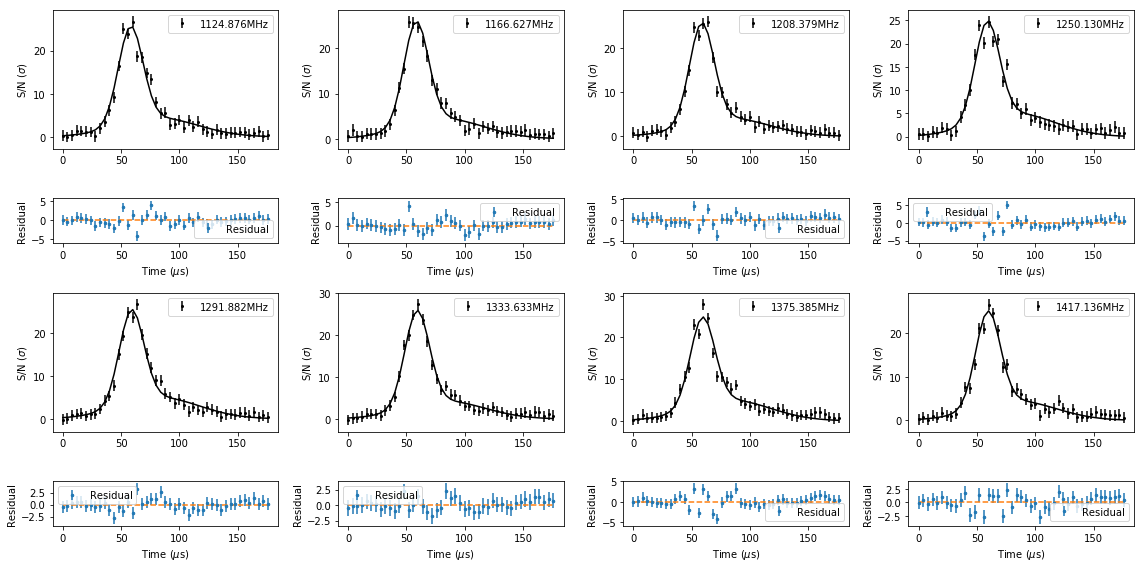

In [23]:
t1,t2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8,dmerr,sigi,sigi2,sigma=values_toplot[:-2]
def plot_residual(time,y,ydata,sigma,figname="residuals"):

    gs=GridSpec(3*2,4)
    #gs.update(left=0.2, right=0.85, wspace=0.05,top=0.99,bottom=0.08)
    fig=plt.figure(figsize=(16,8))
    #olor_range=["red","blue","black","green"]
    for i in range(len(y)):
        #print(i,(i//4*3),(2+i//4*3),i%4)
        t1,t2=(i//4*3),(2+i//4*3)
        ax1=fig.add_subplot(gs[t1:t2,i%4])
        ax1.plot(time,y[i],color='black')
        ax1.set_ylabel("S/N ($\sigma$)")
        ax1.errorbar(time,ydata[i],yerr=sigma,fmt='o',ms=2,label="{0:.3f}".format(vi[i])+"MHz",color="black")
        plt.legend()
    #gs.update(wspace=0.5, hspace=1.0)
        ax2=fig.add_subplot(gs[t2,i%4],sharex=ax1)
        ax2.errorbar(time,(ydata[i]-y[i]),yerr=sigma,fmt='.',ms=5,label="Residual")
        #ax2.scatter(time,(ydata[i]-y[i])/sigma,s=5,label="residual in band"+str(i))

        ax2.plot(time,np.zeros(len(time)),"--")
        ax2.set_ylabel("Residual")
        ax2.set_xlabel("Time ($\\mu$s)")
        plt.tight_layout()
        plt.legend()

        #plt.savefig(figname+"band"+str(i)+".png",dpi=200)
    plt.savefig(figname+"residuals.png",dpi=200)
    plt.show()
#y=multipulse(time,t0,tau1,a1,a2,a3,a4,a5,a6,a7,a8,dmerr,sigi,alpha)
y=multiband_double(time,t1,t2,dmerr,sigi,sigi2,a1,a2,a3,a4,a5,a6,a7,a8,b1,b2,b3,b4,b5,b6,b7,b8)
plot_residual(time,y,ydata,sigma,o)

### look into structure behind